<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/preparingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SENTIMENT ANALYSIS**

# ![picture](http://t-redactyl.io/figure/Vader_1.jpg)
[Jodie Burchell site's image](http://t-redactyl.io/)





# Set-Up


## Kaggle's API

In [0]:
!pip install -q kaggle
!mkdir .kaggle

In [0]:
import json
token = {"username":"jjordana16","key":"6e806145f7c3fdd4c09e7299f3a70d73"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [8]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content

- path is now set to: /content


In [9]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 15.9MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 82.7MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 97.7MB/s]


## Importing Libraries & data

In [6]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import re, string

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

## Used for creating the words graphs
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

# Listing all the files in our folder
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
test = pd.read_csv('/content/competitions/tweet-sentiment-extraction/test.csv')
train = pd.read_csv('/content/competitions/tweet-sentiment-extraction/train.csv.zip')

# EDA

Our first main target is going to be the analysis of all our tweets data. We are going to focus first on the `training set`.<br>

We have distinguish three types of sentiments: `positive`, `neutral`, and `negative`. <br> The main aim if this [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction) is to get the words that have the highest weight for deciding the sentiment of a tweet. Therefore, the sentiment has already been stablished, we do not need to get it.<br>
However, I found crucial to understand how `sentiment analysis` works before going on a further level.

In our `training data`, `neutral` tweets are the most common ones, followed by `positive`tweets. Let's try to plot which are the most common words in all these three types of text.

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Train Sentiment Count')

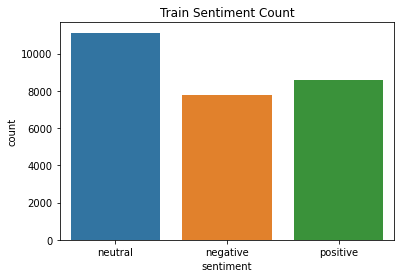

In [11]:
print(train['sentiment'].value_counts())
sns.countplot(x='sentiment', data=train).set_title('Train Sentiment Count')

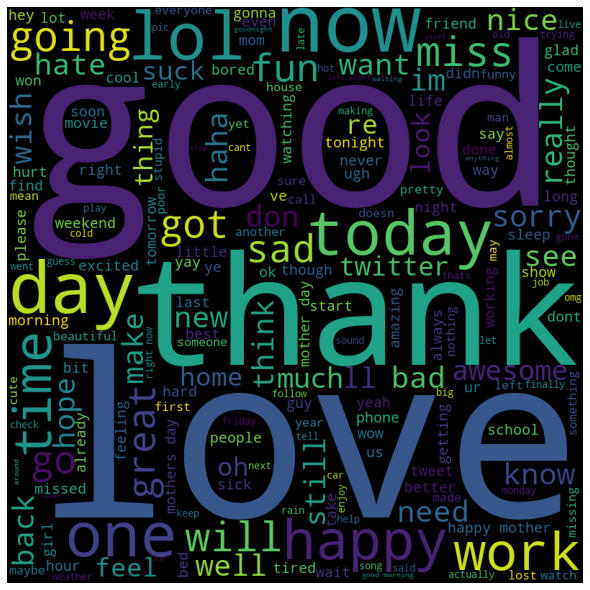

In [12]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train['selected_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 